In [1]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')


Verisetimizi yüklüyoruz

In [2]:
path="laptopPrice.csv"
data=pd.read_csv(path)


Verisetimizi keşif için bir fonksiyon ve sonra çalıştırıyoruz

In [3]:
def explore_dataset(df):
    print("\n" + "="*50)
    print(f"📊 Dataset Overview")
    print("="*50)

    print(f"\n🔹 Shape: {df.shape}")
    print("\n🔹 Column Types:")
    print(df.dtypes)

    print("\n🔹 Missing Values:")
    print(df.isnull().sum())

    print("\n🔹 General Info:")
    print(df.info())

    print("\n🔹 Statistical Summary:")
    print(tabulate(df.describe(), headers='keys', tablefmt='grid'))

    print("\n🔹 First 5 Rows:")
    print(tabulate(df.head(), headers='keys', tablefmt='fancy_grid'))

    print("\n🔹 Last 5 Rows:")
    print(tabulate(df.tail(), headers='keys', tablefmt='fancy_grid'))

    print("="*50)


In [4]:
explore_dataset(data)


📊 Dataset Overview

🔹 Shape: (823, 19)

🔹 Column Types:
brand                object
processor_brand      object
processor_name       object
processor_gnrtn      object
ram_gb               object
ram_type             object
ssd                  object
hdd                  object
os                   object
os_bit               object
graphic_card_gb      object
weight               object
warranty             object
Touchscreen          object
msoffice             object
Price                 int64
rating               object
Number of Ratings     int64
Number of Reviews     int64
dtype: object

🔹 Missing Values:
brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating    

Null değerimiz yok gibi gözüküyor. Bunun yanısıra bazı sütunlar aslında nümerik veri olarak kullanılabilir. Aşağıda bazı sütunları nümerik veriye çevirdim. Bazılarının adını değiştirdim daha rahat işlem yapabilmek için

In [5]:
data['ram_gb'] = data['ram_gb'].str.replace('GB', '').astype(int)
data['ssd']= data['ssd'].str.replace('GB', '').astype(int)
data['hdd']= data['hdd'].str.replace('GB', '').astype(int)
data['graphic_card_gb']= data['graphic_card_gb'].str.replace('GB', '').astype(int)
data['rating'] = data['rating'].str.replace(r'\D', '', regex=True).astype(int)
data['warranty']=data['warranty'].str.replace('No warranty','0')
data['warranty']=data['warranty'].str.replace(r'\D','',regex=True).astype(int)

data['num_ratings']=data['Number of Ratings']
data['num_reviews']=data['Number of Reviews']
data=data.drop(columns=['Number of Ratings','Number of Reviews'])




Kontrol ediyoruz yaptığımız değişiklikleri

In [6]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            823 non-null    object
 1   processor_brand  823 non-null    object
 2   processor_name   823 non-null    object
 3   processor_gnrtn  823 non-null    object
 4   ram_gb           823 non-null    int64 
 5   ram_type         823 non-null    object
 6   ssd              823 non-null    int64 
 7   hdd              823 non-null    int64 
 8   os               823 non-null    object
 9   os_bit           823 non-null    object
 10  graphic_card_gb  823 non-null    int64 
 11  weight           823 non-null    object
 12  warranty         823 non-null    int64 
 13  Touchscreen      823 non-null    object
 14  msoffice         823 non-null    object
 15  Price            823 non-null    int64 
 16  rating           823 non-null    int64 
 17  num_ratings      823 non-null    in

,ram_gb,ssd,hdd,graphic_card_gb,warranty,Price,rating,num_ratings,num_reviews
count,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000
mean,8.680437,452.121507,227.071689,1.190765,0.721750,76745.177400,3.562576,315.301337,37.609964
std,4.372408,316.662592,413.105282,2.026902,0.593231,45101.790525,0.567282,1047.382654,121.728017
min,4.000000,0.000000,0.000000,0.000000,0.000000,16990.000000,1.000000,0.000000,0.000000
25%,4.000000,256.000000,0.000000,0.000000,0.000000,46095.000000,3.000000,0.000000,0.000000
50%,8.000000,512.000000,0.000000,0.000000,1.000000,64990.000000,4.000000,17.000000,2.000000
75%,8.000000,512.000000,0.000000,2.000000,1.000000,89636.000000,4.000000,139.500000,18.000000
max,32.000000,3072.000000,2048.000000,8.000000,3.000000,441990.000000,5.000000,15279.000000,1947.000000


SSD HDD gibi değerler  sıfır olamaz. En azından birini mode değeriyle dolduracak fonksiyon yazıyorum.

In [7]:
def replace_zero_with_mode_randomly(row):
    if row['ssd'] == 0 and row['hdd'] == 0:
      column_choice = np.random.choice(['ssd', 'hdd'])
      if column_choice == 'ssd':
        row['ssd'] = data['ssd'].mode()[0]
      else:
        row['hdd'] = data['hdd'].mode()[0]
    return row

data=data.apply(replace_zero_with_mode_randomly,axis=1)

#Cleaned datayı burada yedekliyoruz.
data_cleaned=data.copy()


Price ile değişkenler arasında ilişkiyi inceliyoruz.

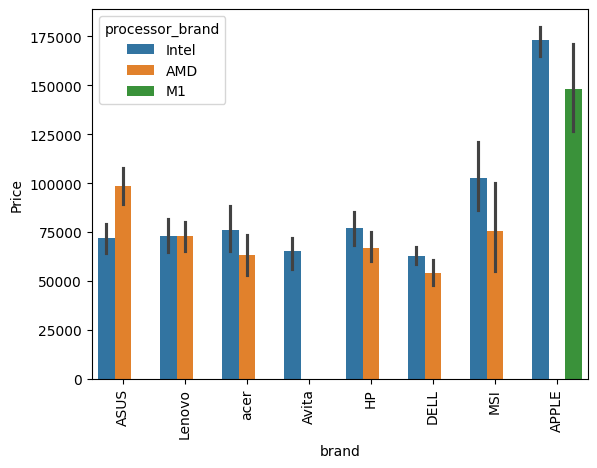

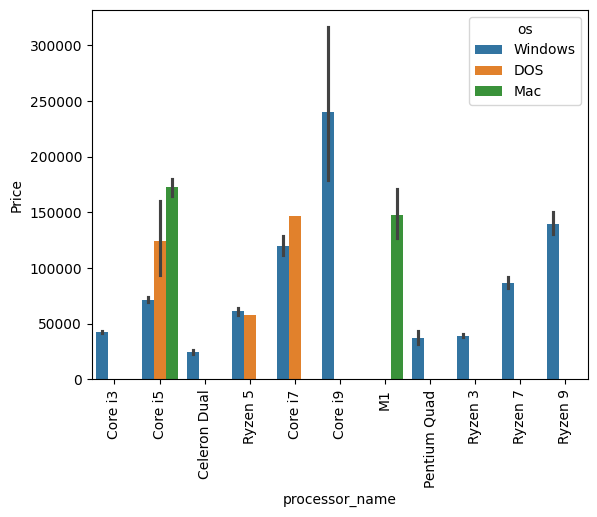

([0, 1, 2],
 [Text(0, 0, 'Casual'), Text(1, 0, 'ThinNlight'), Text(2, 0, 'Gaming')])

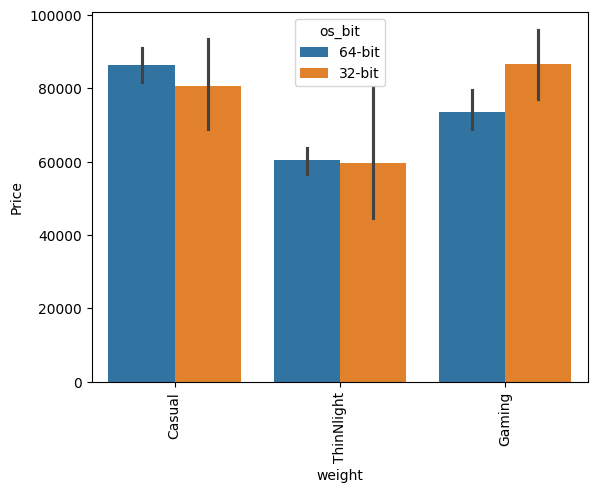

In [8]:
sns.barplot(data=data_cleaned,x='brand',y='Price',hue='processor_brand')
plt.xticks(rotation=90)
plt.show()

sns.barplot(data=data_cleaned,x='processor_name',y='Price',hue='os')
plt.xticks(rotation=90)
plt.show()

sns.barplot(data=data_cleaned,x='weight',y='Price',hue='os_bit')
plt.xticks(rotation=90)

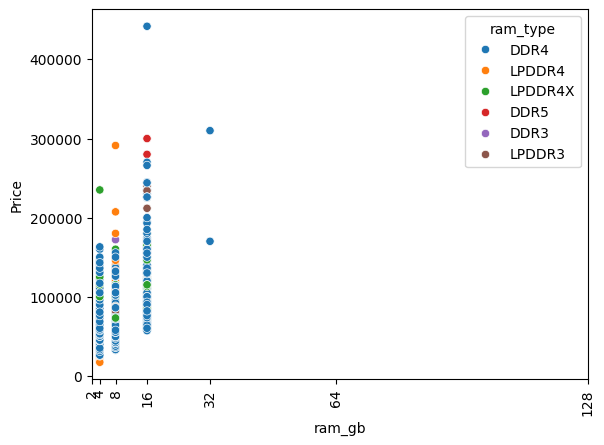

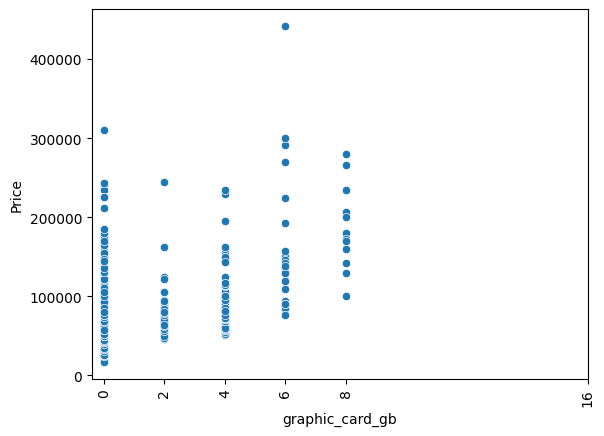

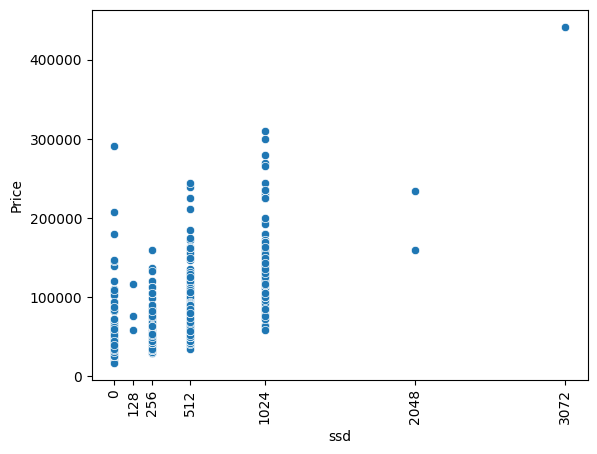

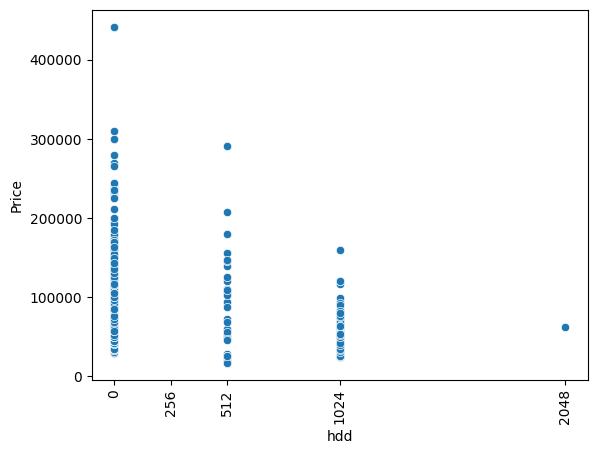

In [9]:

ram_values=[2,4,8,16,32,64,128]

sns.scatterplot(data=data_cleaned,x='ram_gb',y='Price',hue='ram_type',)
plt.xticks(ram_values, ram_values)
plt.xticks(rotation=90)
plt.show()


graphic_card_gb=[0,2,4,6,8,16]

sns.scatterplot(data=data_cleaned,x='graphic_card_gb',y='Price')
plt.xticks(graphic_card_gb, graphic_card_gb)
plt.xticks(rotation=90)
plt.show()


ssd_values=[0, 128, 256, 512, 1024, 2048, 3072]
sns.scatterplot(data=data_cleaned,x='ssd',y='Price')
plt.xticks(ssd_values, ssd_values)
plt.xticks(rotation=90)
plt.show()

hdd_values=[0, 256, 512, 1024, 2048]
sns.scatterplot(data=data_cleaned,x='hdd',y='Price')
plt.xticks(hdd_values, hdd_values)
plt.xticks(rotation=90)
plt.show()

Sayısal değişkenlerimizin dağılımını inceliyoruz

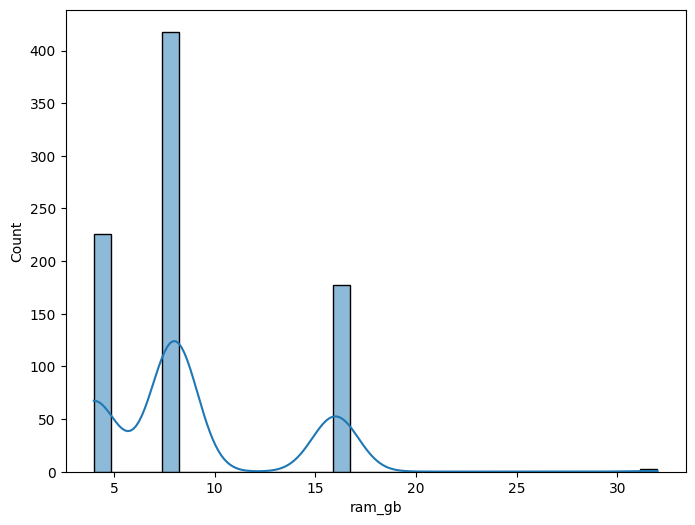

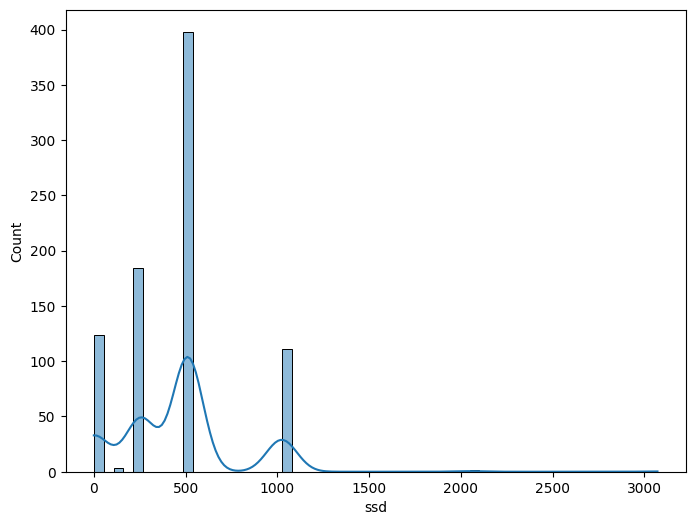

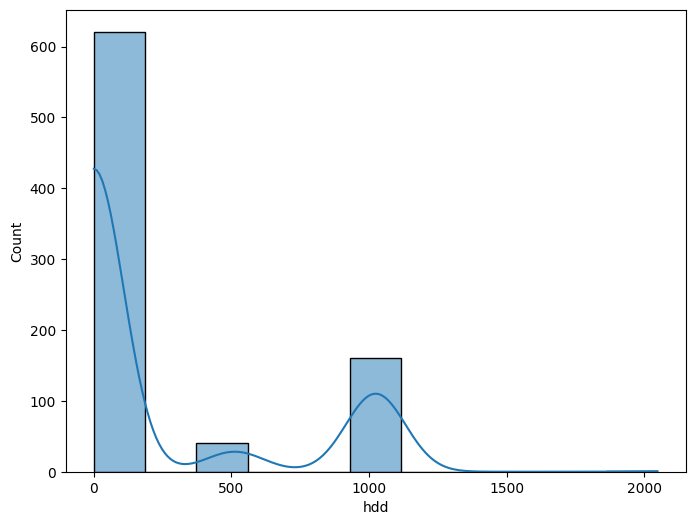

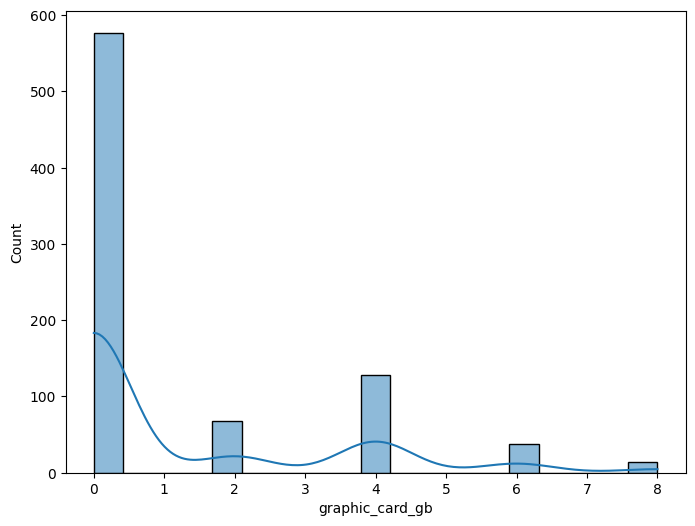

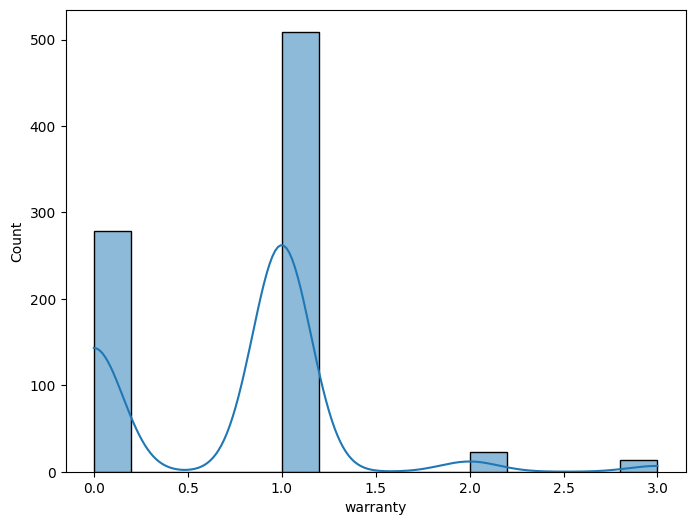

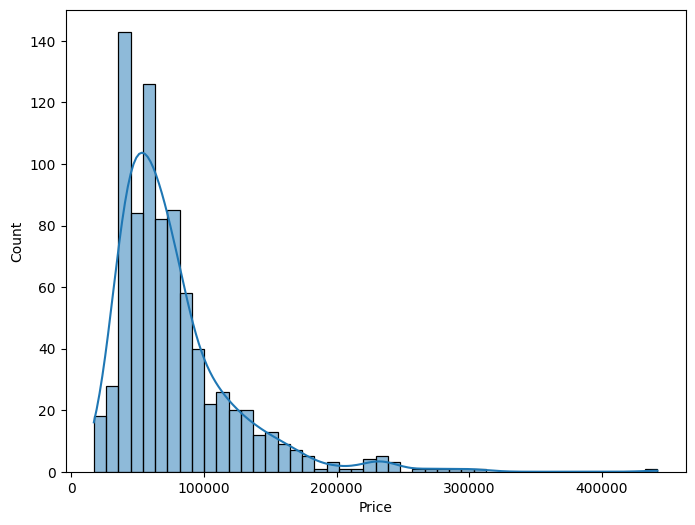

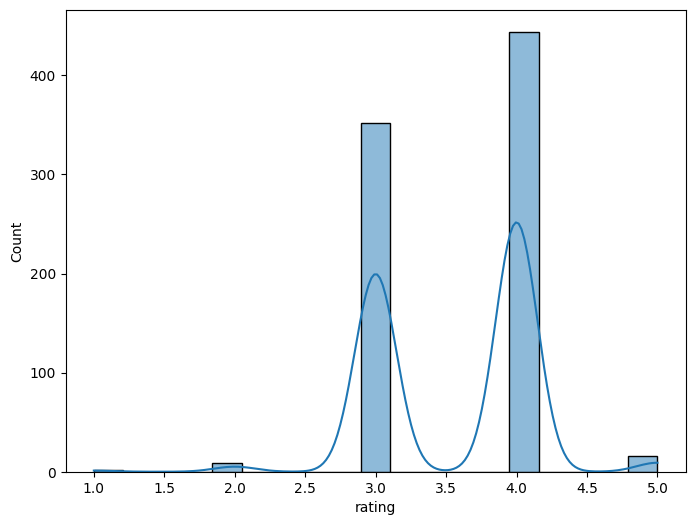

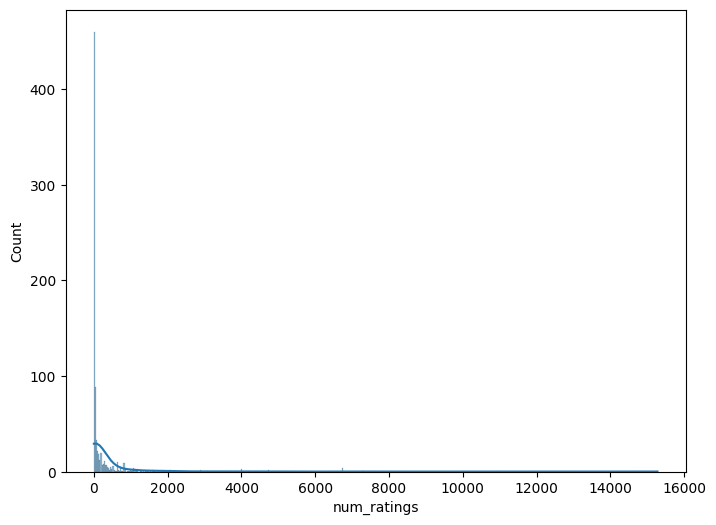

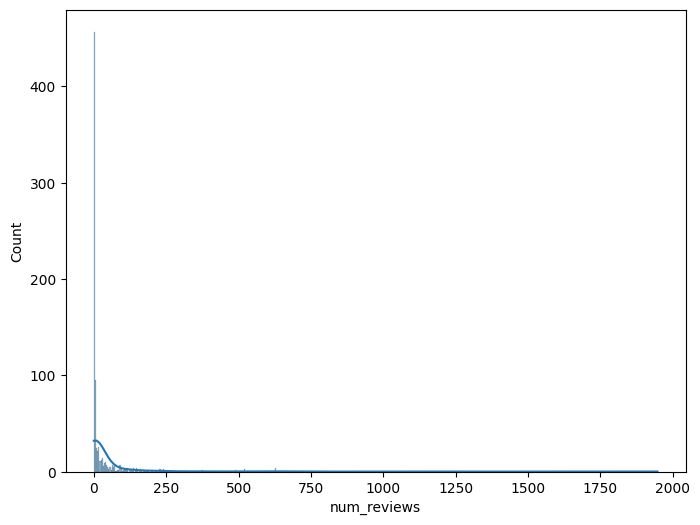

In [10]:
for column in data.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], kde=True)

Nümerik değişkenlerimizden Outlierlar değerleri temizleyip minmax scale ile normalize ediyoruz.

In [11]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df[column]

for col in numerical_columns:
    data[col] = handle_outliers(data, col)





data[numerical_columns] = np.log1p(data[numerical_columns])



Geride kalan  kategorik sütunlara encoding işlemleri yapmak için eşsiz değerlerine bakalım

In [12]:
categorical_columns = data.select_dtypes(include='object').columns
for column in categorical_columns:
    print(f"Unique values in {column}:")
    print(data[column].unique())

Unique values in brand:
['ASUS' 'Lenovo' 'acer' 'Avita' 'HP' 'DELL' 'MSI' 'APPLE']
Unique values in processor_brand:
['Intel' 'AMD' 'M1']
Unique values in processor_name:
['Core i3' 'Core i5' 'Celeron Dual' 'Ryzen 5' 'Core i7' 'Core i9' 'M1'
 'Pentium Quad' 'Ryzen 3' 'Ryzen 7' 'Ryzen 9']
Unique values in processor_gnrtn:
['10th' 'Not Available' '11th' '7th' '8th' '9th' '4th' '12th']
Unique values in ram_type:
['DDR4' 'LPDDR4' 'LPDDR4X' 'DDR5' 'DDR3' 'LPDDR3']
Unique values in os:
['Windows' 'DOS' 'Mac']
Unique values in os_bit:
['64-bit' '32-bit']
Unique values in weight:
['Casual' 'ThinNlight' 'Gaming']
Unique values in Touchscreen:
['No' 'Yes']
Unique values in msoffice:
['No' 'Yes']


İşlemcilerin Nesilleri için bir label encoding gerçekleştireceğim 'No Generation'ı değiştirmek istediğimizden ne yapacağımıza karar vermek için 'No generation' gözüken işlemcilere bakıyoruz. Ardından en çok gözüken işlemci tipine bakıyoruz.

In [13]:
print("Not Available: ")
print(data.loc[data['processor_gnrtn'] == 'Not Available', 'processor_name'].unique())
print("-------------------------------------")
print(data.groupby('processor_gnrtn').size())
print("-------------------------------------------")
print(data.groupby('processor_gnrtn')['processor_name'].value_counts())



Not Available: 
['Celeron Dual' 'Core i5' 'Pentium Quad' 'Ryzen 3' 'Ryzen 5' 'Ryzen 7'
 'Ryzen 9']
-------------------------------------
processor_gnrtn
10th             204
11th             334
12th               3
4th                1
7th                9
8th               41
9th                6
Not Available    225
dtype: int64
-------------------------------------------
processor_gnrtn  processor_name
10th             Core i5            75
                 Core i3            65
                 Core i7            34
                 M1                 24
                 Ryzen 5             4
                 Core i9             2
11th             Core i5           176
                 Core i3            96
                 Core i7            57
                 Core i9             5
12th             Core i7             2
                 Core i9             1
4th              Core i5             1
7th              Core i5             7
                 Core i3             2
8th  

Bu edindiğim bilgiler göre işlemci nesillerini şu şekilde encode etmek istiyorum. Kodda görebileceğiniz gibi her amd işlemciyi intel karşılığındaki en çok değerle eşleştiriyorum. Bunu yapmamın sebebi intelden daha eski nesil isimlerine sahip olmalarına rağmen amd işlemciler benzer düzeyde güç düzeyine sahipler. Celeron Pentium gibi işlemcileri eski nesillerle ilişkilendirmem daha doğru olur.

---
R3: i3 ➔ 10

R5: i5 ➔ 10

R7: i7 ➔ 11

R9: i9 ➔ 11

Celeron/Pentium ➔ 8

---





In [14]:
# Sayısal nesil bilgilerini çıkart
data["processor_gnrtn"] = data["processor_gnrtn"].str.extract('(\d+)').astype(float)

# Ryzen ve Intel nesillerini eşleştiren fonksiyon
def assign_generation(row):
    if pd.isna(row["processor_gnrtn"]):  # Eğer nesil bilgisi yoksa
        if "Ryzen 3" in row["processor_name"]:
            return 10  # Core i3 teknolojisine yakın
        elif "Ryzen 5" in row["processor_name"]:
            return 10  # Core i5 teknolojisine yakın
        elif "Ryzen 7" in row["processor_name"]:
            return 11  # Core i7 teknolojisine yakın
        elif "Ryzen 9" in row["processor_name"]:
            return 11  # Core i9 teknolojisine yakın
        elif "Celeron Dual" in row["processor_name"]:
            return 8  # Giriş seviyesi işlemciler genelde eski
        elif "Pentium Quad" in row["processor_name"]:
            return 8  # Pentium'lar biraz daha güncel olabilir
        elif "Core i5" in row["processor_name"]:
            return 10  # Eğer Core i5 olup nesli yoksa, genellikle 8th nesil
        else:
            return data["processor_gnrtn"].mode()[0]  # Kalan tüm durumlarda ortanca değeri kullan
    return row["processor_gnrtn"]

data["processor_gnrtn"] = data.apply(assign_generation, axis=1)

print(data["processor_gnrtn"].unique())




data["processor_gnrtn"]=np.log1p(data["processor_gnrtn"])




[10.  8. 11.  7.  9.  4. 12.]


Geri kalan kategorik değişkenlerin encoding işlemlerini yapıyoruz

In [15]:

one_hot_encoded_cols = ["brand", "processor_name","ram_type","processor_brand", "weight"]

for col in one_hot_encoded_cols:
    encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False ile dense matris elde edilir.
    encoded_data = encoder.fit_transform(data[[col]])  # Veriyi encode et
    # Yeni sütunları data'ya ekleyelim
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([col]))  # Yeni sütun isimleri
    data = pd.concat([data, encoded_df], axis=1)  # Yeni sütunları birleştirme
    data = data.drop(columns=[col])  # Orijinal kategorik sütunu silebiliriz

label_encoded_cols = ["os_bit", "Touchscreen", "msoffice", "os"]

for col in label_encoded_cols:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])

Şimdi  veri setimize tekrar bakıyoruz yapılan encoding işlemleri sonrası.

In [16]:
explore_dataset(data)


📊 Dataset Overview

🔹 Shape: (823, 45)

🔹 Column Types:
processor_gnrtn                float64
ram_gb                         float64
ssd                            float64
hdd                            float64
os                               int64
os_bit                           int64
graphic_card_gb                float64
warranty                       float64
Touchscreen                      int64
msoffice                         int64
Price                          float64
rating                         float64
num_ratings                    float64
num_reviews                    float64
brand_APPLE                    float64
brand_ASUS                     float64
brand_Avita                    float64
brand_DELL                     float64
brand_HP                       float64
brand_Lenovo                   float64
brand_MSI                      float64
brand_acer                     float64
processor_name_Celeron Dual    float64
processor_name_Core i3         float64
process

Verisetimizi uygun şekilde bölüyoruz

In [17]:
features=data.drop(columns=['Price'])
target=data['Price']

X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

Modelimize sokuyoruz veri setimizi.

In [18]:
Lr=LinearRegression()
Lr.fit(X_train,y_train)

lr_pred=Lr.predict(X_test)

Metriklere bakıyoruz

In [19]:
r2=r2_score(y_test,lr_pred)
mse=mean_squared_error(y_test,lr_pred)
rmse=np.sqrt(mse)

print("R2: ",r2)
print("MSE: ",mse)
print("RMSE: ",rmse)

R2:  0.8207123665055842
MSE:  0.03502772146064149
RMSE:  0.18715694339415112


Ridge ile modelimizi r2 skorunu  arttırmaya çalışıyoruz

In [20]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Ridge regresyon modeli
ridge_params = {'alpha': np.logspace(-3, 3, 50)}  # Alpha değerleri için geniş bir aralık
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, scoring='r2', cv=5)  # Çapraz doğrulama ile en iyi alpha değerini bulma
ridge_grid.fit(X_train, y_train)

# En iyi Ridge modeli
best_ridge = ridge_grid.best_estimator_

# Ridge katsayılarını alma
ridge_coefficients = best_ridge.coef_

# Test setinde tahmin yapma
y_pred_ridge = best_ridge.predict(X_test)

# Performans değerlendirmesi
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
ridge_best_alpha = ridge_grid.best_params_['alpha']

# Sonuçları yazdır
print(f"Ridge Modeli (En iyi Alpha: {ridge_best_alpha}):")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"R^2 Skoru: {r2_ridge}")
print("Ridge Katsayıları:", ridge_coefficients)

Ridge Modeli (En iyi Alpha: 0.28117686979742307):
Mean Squared Error (MSE): 0.03490208802960187
R^2 Skoru: 0.8213554149140907
Ridge Katsayıları: [ 0.08068244  0.07642064  0.01863466  0.         -0.18622708 -0.01473649
  0.12650282  0.03566093  0.20230628 -0.0399317   0.10355047 -0.07195033
  0.06096069  0.48808858 -0.09095909 -0.16373972 -0.04448628  0.00887315
 -0.05077901 -0.09354772 -0.05344991 -0.62358306 -0.21024513  0.1356368
  0.40786114  0.60200812  0.01390118 -0.38089687 -0.43641036 -0.11764936
  0.11625365  0.49312388  0.05085041 -0.17576472  0.10533813  0.2135442
 -0.12328755 -0.07068047  0.06864249 -0.08254367  0.01390118  0.0300003
 -0.07060226  0.04060196]


Lasso Deniyoruz

In [21]:
from sklearn.linear_model import Lasso
# Lasso regresyon modeli
lasso_params = {'alpha': np.logspace(-3, 0, 50)}  # Lasso için daha küçük bir alpha aralığı
lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso, lasso_params, scoring='r2', cv=5)
lasso_grid.fit(X_train, y_train)

# En iyi Lasso modeli
best_lasso = lasso_grid.best_estimator_

# Lasso katsayılarını alma
lasso_coefficients = best_lasso.coef_

# Test setinde tahmin yapma
y_pred_lasso = best_lasso.predict(X_test)

# Performans değerlendirmesi
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
lasso_best_alpha = lasso_grid.best_params_['alpha']

# Sonuçları yazdır
print(f"Lasso Modeli (En iyi Alpha: {lasso_best_alpha}):")
print(f"Mean Squared Error (MSE): {mse_lasso}")
print(f"R^2 Skoru: {r2_lasso}")
print("Lasso Katsayıları:", lasso_coefficients)


Lasso Modeli (En iyi Alpha: 0.001):
Mean Squared Error (MSE): 0.03308917091457456
R^2 Skoru: 0.8306347401376851
Lasso Katsayıları: [ 0.          0.09088719  0.02363019  0.         -0.17061404 -0.0023364
  0.13187509  0.02636816  0.18885663 -0.0224393   0.         -0.06079743
  0.04584905  0.51797641 -0.02777083 -0.06481268  0.          0.05215939
 -0.         -0.00805702  0.         -0.75255222 -0.32244372  0.
  0.25294982  0.38073152  0.         -0.46808715 -0.36737939 -0.08465333
  0.12340218  0.47083119  0.         -0.12881151  0.02370409  0.19969398
 -0.01995234 -0.          0.         -0.          0.          0.
 -0.08466007  0.        ]


En çok etki eden özelliğe bakıyoruz skorumuzu arttırmak için

In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# Modeli seç
model = Ridge()

# RFE uygulaması
rfe = RFE(model, n_features_to_select=5)  # Seçilecek özellik sayısı
fit = rfe.fit(X_test, y_test)

# Seçilen özellikleri yazdır
selected_features = [column for column, support in zip(X_test, fit.support_) if support]
print("Selected Features:", selected_features)


Selected Features: ['processor_name_Celeron Dual', 'processor_name_Core i3', 'processor_name_Pentium Quad', 'processor_name_Ryzen 3', 'processor_name_Ryzen 9']


Tüm nümerik değişkenleri scaler kullanmak yerine logaritmik transformasyona uğratınca gözle görülür 0.10 r2 puanına yakın bir artış sağlandı. Base model 0.7'den 0.81'e çıktı.

Skorun arttırılması için eklenen özellikler

In [23]:
data["proccessor_gen_ram_interaction"]=np.expm1(data["processor_gnrtn"])*np.expm1(data["ram_gb"])
data["proccessor_gen_ram_interaction"]=np.log1p(data["proccessor_gen_ram_interaction"])

data['processor_gpu_interaction'] = np.expm1(data['processor_gnrtn']) * np.expm1(data['graphic_card_gb'])
data['processor_gpu_interaction'] = np.log1p(data['processor_gpu_interaction'])

data['processor_ssd_interaction'] = np.expm1(data['processor_gnrtn']) * np.expm1(data['ssd'])
data['processor_ssd_interaction'] = np.log1p(data['processor_ssd_interaction'])

data['ssd_hdd_ratio'] = np.expm1(data['ssd']) / (np.expm1(data['hdd'])+1e-5)
data['ssd_hdd_ratio'] = np.log1p(data['ssd_hdd_ratio'])



Tekrar modellere sokuyoruz

In [24]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

features=data.drop(columns=['Price'])
target=data['Price']

lr=LinearRegression()

X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)
lr.fit(X_train,y_train)

lr_pred=lr.predict(X_test)

r2=r2_score(y_test,lr_pred)
mse=mean_squared_error(y_test,lr_pred)
rmse=np.sqrt(mse)

print("R2: ",r2)
print("MSE: ",mse)
print("RMSE: ",rmse)

R2:  0.8414674266751939
MSE:  0.030972771030707967
RMSE:  0.17599082655271542


Ridge

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Ridge regresyon modeli
ridge_params = {'alpha': np.logspace(-3, 3, 50)}  # Alpha değerleri için geniş bir aralık
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, scoring='r2', cv=5)  # Çapraz doğrulama ile en iyi alpha değerini bulma
ridge_grid.fit(X_train, y_train)

# En iyi Ridge modeli
best_ridge = ridge_grid.best_estimator_

# Ridge katsayılarını alma
ridge_coefficients = best_ridge.coef_

# Test setinde tahmin yapma
y_pred_ridge = best_ridge.predict(X_test)

# Performans değerlendirmesi
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
ridge_best_alpha = ridge_grid.best_params_['alpha']

# Sonuçları yazdır
print(f"Ridge Modeli (En iyi Alpha: {ridge_best_alpha}):")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"R^2 Skoru: {r2_ridge}")
print("Ridge Katsayıları:", ridge_coefficients)

Ridge Modeli (En iyi Alpha: 0.0017575106248547913):
Mean Squared Error (MSE): 0.03104653546407111
R^2 Skoru: 0.8410898671268632
Ridge Katsayıları: [ 2.89088841  2.58214673  0.63075796  0.         -0.16614543 -0.00415283
  0.59082875  0.02654873  0.1951999  -0.03674948  0.1462301  -0.07528177
  0.06816066  0.43899691 -0.09002078 -0.16341589 -0.0104687   0.01336832
 -0.03864209 -0.10308271 -0.04673504 -0.59976264 -0.19395812  0.16915235
  0.37586226  0.51729181  0.03873684 -0.37015124 -0.41644974 -0.09861138
  0.12105822  0.45683162  0.06230319 -0.16671574  0.09405335  0.19134847
 -0.11002297 -0.07096629  0.04141409 -0.08015093  0.03873684  0.03542896
 -0.06521504  0.02978608 -2.22253844 -0.20180697 -0.56709867  0.05763371]


Modelimizi streamlit'de kullanmak üzere kaydediyoruz.

In [26]:
import joblib


model_path="streamlit_app/model.pkl"

joblib.dump(best_ridge, model_path)

import pickle


data_path = "streamlit_app/dataset.pkl"

with open(data_path, "wb") as f:
    pickle.dump(data, f)
